## Transformer

/tmp/ipython-input-3-601235090.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/100], Training Loss: 0.3429
Epoch [1/100], Validation Loss: 2.9556
Epoch [1/100], Test Loss: 1.9566
Epoch [2/100], Training Loss: 5.8902
Epoch [2/100], Validation Loss: 0.7789
Epoch [2/100], Test Loss: 0.8418
Epoch [3/100], Training Loss: 0.5810
Epoch [3/100], Validation Loss: 0.9001
Epoch [3/100], Test Loss: 0.7063
Epoch [4/100], Training Loss: 1.0483
Epoch [4/100], Validation Loss: 0.1424
Epoch [4/100], Test Loss: 1.6765
Epoch [5/100], Training Loss: 0.7055
Epoch [5/100], Validation Loss: 0.5174
Epoch [5/100], Test Loss: 3.4307
Epoch [6/100], Training Loss: 0.3781
Epoch [6/100], Validation Loss: 1.1409
Epoch [6/100], Test Loss: 4.5258
Epoch [7/100], Training Loss: 0.4159
Epoch [7/100], Validation Loss: 1.3101
Epoch [7/100], Test Loss: 4.4574
Epoch [8/100], Training Loss: 0.4560
Epoch [8/100], Validation Loss: 1.0438
Epoch [8/100], Test Loss: 3.5487
Epoch [9/100], Training Loss: 0.3640
Epoch [9/100], Validation Loss: 0.5892
Epoch [9/100], Test Loss: 2.2911
Epoch [10/100], Tra

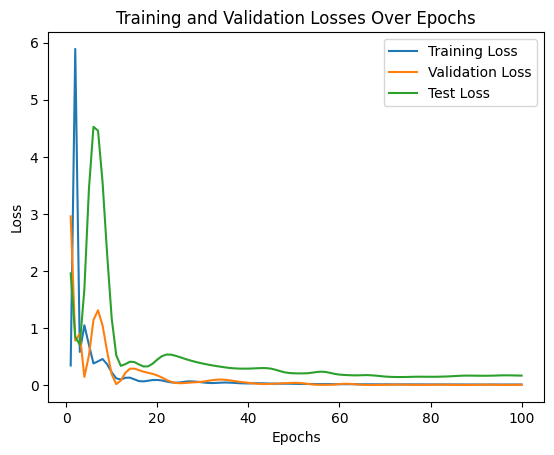

Final Test Loss: 0.1660

Validation Set Metrics:
Mean Absolute Error (MAE): 0.0410
Mean Squared Error (MSE): 0.0047
Root Mean Squared Error (RMSE): 0.0685
Mean Absolute Percentage Error (MAPE): 37.2103

Test Set Metrics:
Mean Absolute Error (MAE): 0.1937
Mean Squared Error (MSE): 0.1660
Root Mean Squared Error (RMSE): 0.4075
Mean Absolute Percentage Error (MAPE): 8.6902


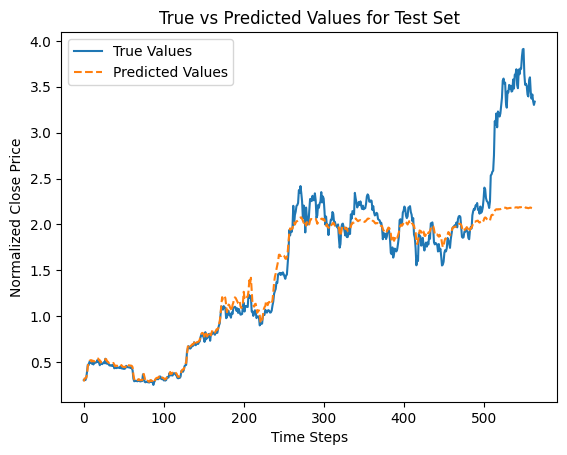

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define the stock symbol and date range
stock_symbol = "BTC-USD"
start_date = "2013-01-01"
end_date = "2025-01-01"

# Fetch historical stock data from Yahoo Finance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Reset index to make 'Date' a column again
stock_data.reset_index(inplace=True)

# Use 'Date' as index
stock_data.set_index('Date', inplace=True)

# Normalize data
columns_to_normalize = ['Low', 'Open', 'Volume', 'High', 'Close']
data_to_normalize = stock_data[columns_to_normalize].values

# Convert the data to PyTorch tensor
tensor_data = torch.tensor(data_to_normalize, dtype=torch.float32)

# Calculate mean and standard deviation for each column
mean = tensor_data.mean(dim=0)
std = tensor_data.std(dim=0)

# Normalize the data
normalized_data = (tensor_data - mean) / std

# Convert the normalized data back to a DataFrame
df_normalized = pd.DataFrame(normalized_data.numpy(), columns=columns_to_normalize)

# Add 'Date' column back to the DataFrame
df_normalized['Date'] = stock_data.index
data = df_normalized

# Define the percentage of data for training, validation, and testing
train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

# Calculate the sizes of the train, validation, and test sets
train_size = int(train_percent * len(data))
val_size = int(val_percent * len(data))
test_size = len(data) - train_size - val_size

# Split the data into train, validation, and test sets
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

# Define the features and target columns
feature_columns = ['Low', 'Open', 'High']
target_column = 'Close'

# Extract features and target for each dataset
train_features = train_data[feature_columns].values
train_target = train_data[target_column].values

val_features = val_data[feature_columns].values
val_target = val_data[target_column].values

test_features = test_data[feature_columns].values
test_target = test_data[target_column].values

# Convert data to PyTorch tensors
train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

# Define a simple Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_attention_heads):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_attention_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers
        )
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Adjust input shape for the transformer
        x = self.transformer(x, x)  # Set source and target as the same data
        x = x.permute(1, 0, 2)  # Restore the original shape
        x = self.fc_output(x[:, -1, :])  # Use the last layer's output for prediction
        return x

# Define hyperparameters
input_size = len(feature_columns)
hidden_size = 64
output_size = 1
num_layers = 2
num_attention_heads = 4
learning_rate = 0.001
num_epochs = 100

# Create the model instance
model = TransformerModel(input_size, hidden_size, output_size, num_layers, num_attention_heads)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training, validation, and test losses
train_losses = []
val_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_features.unsqueeze(1))

    # Calculate the loss
    loss = criterion(outputs, train_target.unsqueeze(1))

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    # Store the training loss
    train_losses.append(loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}')

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_features.unsqueeze(1))
        val_loss = criterion(val_outputs, val_target.unsqueeze(1))

    # Store the validation loss
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss.item():.4f}')

    # Test loss
    with torch.no_grad():
        test_outputs = model(test_features.unsqueeze(1))
        test_loss = criterion(test_outputs, test_target.unsqueeze(1))

    # Store the test loss for each epoch
    test_losses.append(test_loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss.item():.4f}')

# Plotting the training and validation losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.show()


# Print the test loss for the last epoch
print(f'Final Test Loss: {test_losses[-1]:.4f}')
print()

# Switch the model to evaluation mode
model.eval()

# Make predictions on the validation set
with torch.no_grad():
    val_predictions = model(val_features.unsqueeze(1))

# Convert predictions and targets back to numpy arrays
val_predictions = val_predictions.squeeze(1).numpy()
val_target_numpy = val_target.numpy()

# Calculate evaluation metrics for validation set
mae_val = mean_absolute_error(val_target_numpy, val_predictions)
mse_val = mean_squared_error(val_target_numpy, val_predictions)
rmse_val = np.sqrt(mse_val)
mape_val = calculate_mape(val_target_numpy, val_predictions)

# Print the evaluation metrics for validation set
print('Validation Set Metrics:')
print(f'Mean Absolute Error (MAE): {mae_val:.4f}')
print(f'Mean Squared Error (MSE): {mse_val:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_val:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_val:.4f}')
print()

# Make predictions on the test set
with torch.no_grad():
    test_predictions = model(test_features.unsqueeze(1))

# Convert predictions and targets back to numpy arrays
test_predictions = test_predictions.squeeze(1).numpy()
test_target_numpy = test_target.numpy()

# Calculate evaluation metrics for test set
mae_test = mean_absolute_error(test_target_numpy, test_predictions)
mse_test = mean_squared_error(test_target_numpy, test_predictions)
rmse_test = np.sqrt(mse_test)
mape_test = calculate_mape(test_target_numpy, test_predictions)

# Print the evaluation metrics for test set
print('Test Set Metrics:')
print(f'Mean Absolute Error (MAE): {mae_test:.4f}')
print(f'Mean Squared Error (MSE): {mse_test:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_test:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.4f}')

# Plotting the predicted values against true values for the test set
plt.plot(test_target_numpy, label='True Values')
plt.plot(test_predictions, label='Predicted Values', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Close Price')
plt.title('True vs Predicted Values for Test Set')
plt.legend()
plt.show()
